In [1]:
#Import packages
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt
import timeit
import warnings
import math as mt
from scipy.optimize import fsolve
from numba import jit
from quantecon.markov import DiscreteDP
warnings.filterwarnings("ignore", category=RuntimeWarning)

%matplotlib inline







1 Pose the recursive formulation of the sequential problem without productivity shocks. Discretize the state space and the value function and solve for it under the computational variants listed below. In all these variants use the same initial guess for your value function.
    
First we define the problem en sequential formulation, so we have:
    
\begin{equation*}
\begin{aligned}
& \underset{c,h}{\max}
&& \sum_{t=0}^{\infty}\beta^{t}u(u(c_{t},1-h_{t}= \ln c_{t} - \kappa\dfrac{h_{t}^{1 + \dfrac{1}{v}}}{1+\dfrac{1}{v}})\\
& \text{subject to}
& & c_{t}+i_{t} = y_{t} \\
&&& y_t = k_{t}^{1-\theta}(h_t)^\theta \\
&&& i_{t} =k_{t+1} - (1-\delta)k_{t}
\end{aligned}
\end{equation*}

Now, we normalize $y=1$ and $h_t =1$ we can rewrite the problem as:

\begin{equation*}
\begin{aligned}
& \underset{c,h}{\max}
&& \sum_{t=0}^{\infty}\beta^{t}u(\ln c_{t} - \dfrac{\kappa v}{1+v})\\
& \text{subject to}
& & c_{t}= k_{t}^{1-\theta}+(1-\delta)k_{t}-k_{t+1}
\end{aligned}
\end{equation*}

We use a k' as the control variable, let's define a  \textit{value function}. It gives the sum of discounted utility from the current period conditional on the state variables. The value function for the current problem is $V(k)$.

\begin{equation*}
\begin{aligned}
& \underset{c,h}{\max}
&& \sum_{t=0}^{\infty}\beta^{t}u(\ln c - \dfrac{\kappa v}{1+v})\\
& \text{subject to}
& & c= k^{1-\theta}+(1-\delta)k-k'
\end{aligned}
\end{equation*}

Replace c into the objective function we get:

\begin{equation}
    V(k) = \underset{k' \in \Gamma}{\max}  \ln u(  k^{1-\theta}+(1-\delta)k - k' - \dfrac{\kappa v}{1+v}) +\beta V(k')
 \end{equation}
 \begin{equation}
 \Gamma (k) = \{k' \in R_{+}: k' \leq k^{1-\theta} + (1-\delta)k\}
\end{equation}

Notice that there is not aggregate variables.

Welfare theorem hold, that is, the RCE is Pareto Optimal

Taking the FOC with respect to $k'$

\begin{equation*}
\dfrac{\partial V(k)}{\partial k'} = - \dfrac{1}{k^{1-\theta} + (1-\delta)k - k'} - \lambda_{k} + \beta \dfrac{\partial V(k')}{\partial k'}
\end{equation*}

Now, we have that:

\begin{equation}
\dfrac{\partial V(k')}{\partial k'} = u'_{k}(k')
\end{equation}

By envelopment theory, since we are solving for interior solution, we can solve for capital steady state:

\begin{equation}
\dfrac{1}{k^{1-\theta} + (1-\delta)k - k'} = \beta \dfrac{(1-\theta)k^{\theta}+ (1-\delta)}{k^{1-\theta} + (1-\delta)k - k'}
\end{equation}

so, clearing k:

\begin{equation}
1/\beta -(1-\delta) = (1-\theta)k^{\theta} \rightarrow k^{\theta} = \dfrac{(1- \beta(1-\delta)}{\beta(1-\delta)}
\end{equation}

Finally, we arrive:

\begin{equation}
k_{ss} = \left(\dfrac{1- \beta(1-\delta)}{\beta(1-\delta)}\right)^\dfrac{1}{\theta}
\end{equation}

## Value function iteration

 The value function algorithm holds independently of what method we use to approximate V.
 
Step 1: The continuous variable k is descritezed by defining a grid for the values of $k$, that is, $K=(k_1, k_2, \dots, k_i, \dots, k_p)$ with $k_1 = k_{min}$ and $k_p = k_{max}$.

 To do a grid we need to select $k_{min}$ and $k_{max}$, the first one should be slightly higher than zero and the second should be higher than steady state $k^*$.

In [158]:
#Set the parameters value
beta=0.988   
theta=0.679
delta=0.013
kappa=5.24
nu=2
h=1


In [159]:
qe.tic()
k_ss=(1/(1-theta)*((1/beta)+delta-1))**(-1/theta)
k=np.linspace(0.01,1.5*k_ss,100)

Step 2: Guess a solution $V^{s=0} \in R^{p}$, say the null vector, that is, $V^{s=0}=0 \quad \forall\, i ={1 \dots, p}$. $s$ keeps track the number of iterations.

In [160]:
V = np.empty(shape=[100,350])
# Initial column vector:
V[:,0] = np.zeros((100))


Step 3: Define the return matrix $M$ as follows,
            
       
$$
M=
\begin{bmatrix}
& m(k_1,k_1) & m(k_1,k_2)& \cdots &m(k_1,k_p)  \\
& m(k_2,k_1) & m(k_2,k_2)& \cdots& m(k_2,k_p)\\
& \vdots & \vdots &    \ddots &\vdots\\
&  m(k_p,k_1) & m(k_p,k_2)& \cdots& m(k_p,k_p)\\
\end{bmatrix}
$$              
      
           
The generic element in $M$ contains the return function. $M_{i,j} = m(k_i,k_j) = u(f(k_i) + (1-\delta)k_i - k_j$ evaluated at all possible combinations $k_i \in K$ and $k_j \in K$.

In [161]:
#all possible combinations 
K_i,K_j = np.meshgrid(k,k)

#Feasible combinations
def feasible(k_i,k_j):
    return k_i**(1-theta) + (1-delta)*k_i - k_j

# Evaluating the feasibility of different combinations
N = feasible(K_i,K_j)

# Feasible utility function

def utility(k_i,k_j):
    for i in range(100):
        for j in range(100):
            if N[i,j] >= 0:
                return np.log10(k_i**(1-theta) + (1-delta)*k_i - k_j) - (kappa/(1+(1/nu)))
    
# Define the matrix return

M = utility(K_i,K_j)
M[np.isnan(M)] = -1000000
    

Step 4: Not all values for $c$, hence $k'$, are feasible. The non-negativity restriction on consumption $c_{ij} = f(k_{i}) + (1-\delta)k_{i} - k_{j} \geq 0$, implies that $k_{j} \leq f(k_{i})+ (1-\delta)k_{i}$
        
Therfore, we replace 
$M_{ij} = m(k_{i},k_{j}) = \omega$  if $k_{j} > f(k_{i}) + (1-\delta)k_{i}$, where $\omega$ is a very negative number.

In [162]:
X = np.empty(shape=[100, 100])
G = np.empty(shape=[100, 350])


Step 5: Given the vector $V^{s} = (V_1^s, V_2^s, \cdots, V_{i}^{s}, \cdots V_{p}^{i})$ and the matrix M:
        
First, we compute the matrix $X$:
        
\begin{equation*}
X =
\begin{bmatrix}
& M_{1,1} + \beta V_{1}^{s} & M_{1,2} + \beta V_{2}^{s}  & \cdots & M_{1,p} + \beta V_{p}^{s}  \\
& M_{2,1} + \beta V_{1}^{s} & M_{2,1} + \beta V_{2}^{s}&\cdots&  M_{2,p} + \beta V_{p}^{s}\\
& \vdots & \vdots &    \ddots &\vdots\\
& M_{p,1} + \beta V_{1}^{s} & M_{p,2} + \beta V_{2}^{s}  & \cdots & M_{p,p} + \beta V_{p}^{s}\\
\end{bmatrix}
\end{equation*}

Where the generic element of $X$ is:
        
        
\begin{equation}
X_{i,j} = M_{i,j} + \beta V_{j}^{s}
\end{equation}
        
Second, compute the updated value function $V^{s+1}$ as the maximum element in each row of $X$.
        
\begin{equation}
 V^{s+1} =
\begin{bmatrix}
& \max \{X_{1,1}, X_{1,2}, \cdots, X_{1,P}\}&\\
& \max \{X_{2,1}, X_{2,2}, \cdots, X_{2,P}\}&\\
& \cdots\\
& \max \{X_{P,1}, X_{P,2}, \cdots, X_{P,P}\}&\\
\end{bmatrix}
\end{equation}

Step 6: If $|| V^{s+1} - V^{s}|| < \epsilon$, stop and report success. Otherwise, go back to the previous step, Step 5, replacing $s = s+1$

TOC: Elapsed: 0:00:8.62
Convergence of the value functions took 348 iterations, in 8.620487451553345 seconds.


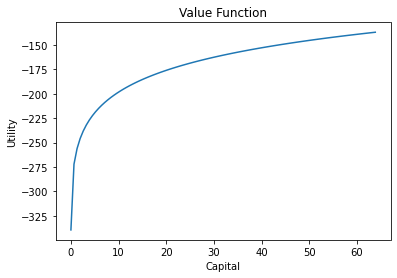

In [95]:
qe.tic()
count=0


for s in range(0,349):
    epsilon=0.01
    for i in range(100):
        for j in range(100):
                X[i,j]=M[i,j]+(beta*V[:,s][j])        
    for i in range(0,100):
        V[:,s+1][i]= np.amax(X[:,i])
        G[:,s][i]=np.argmax(X[:,i])
        for i in range(0,100):
            if abs(V[:,s+1][i]-V[:,s][i])> epsilon:
                continue
            else:
                count +=1
                break
    
T = qe.toc()



plt.plot(k,V[:,349])
plt.title('Value Function')
plt.xlabel('Capital')
plt.ylabel('Utility')




print("Convergence of the value functions took "+str(s)+" iterations, in " + str(T) +" seconds.")

Step 7: Being thorough:
        
Check the bounds of the state space are not binding. Otherwise, relax them.
            
Make sure $\epsilon$ is small enough. Reduce $\epsilon$, redo the VFI, and check your answer does not change. Otherwise, keep reducing $\epsilon$.
            
Make sure the size of the grid, $p$, is large enough. Increase p, redo the VFI and check your answer does not change. Otherwise, keep increasing p.

        
The decision rule is obtained as:
        
\begin{equation*}
 g^{s} =
\begin{bmatrix}
& \arg \max \{X_{1,1}, X_{1,2}, \cdots, X_{1,P}\}&\\
& \arg \max \{X_{2,1}, X_{2,2}, \cdots, X_{2,P}\}&\\
& \cdots\\
& \arg \max \{X_{P,1}, X_{P,2}, \cdots, X_{P,P}\}&\\
\end{bmatrix}
\end{equation*}


## Monotonicity

We reduces the number of points to be searched on the grid by the VFI algorithm. We use the property that the optimal decision rule increase in $k$. Thus, $k_{j} > k_{i}$ then $g(k_{j}) \geq g(k_{i})$, so if we are maximizing we can rule out all values that are smaller than $g(k_i)$.
        
Step 1: For each $k_{i}$, set an optimal lower bound for $g^{s}(k_{i})$ as 
            
\begin{equation*}
   g^{s}(k_{i}) = g^{s}(k_{i-1})
\end{equation*}
            
            
Compute the matrix $X$ only for the pairs $(K-{i},k_{j})$ that satisfy the lower bound, $k_{j} \geq g^{s}(k_i)$. Not every element in $x$ need to be computed. We need to store the decision rule at the end of each iteration.

We use the matrix that we have already define in the previous exercise.

TOC: Elapsed: 0:00:38.17


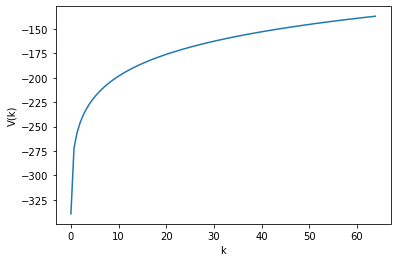

Convergence of the value functions took 348 iterations, in 38.17312145233154 seconds.


In [98]:
qe.tic()
count=0
epsilon=0.01

X = np.empty(shape=[100,100])
G = np.empty(shape=[100, 350])

for s in range(0,349):
    for i in range(100):
        for j in range(100):
            if j >= G[:,s+1][i]: 
                X[i,j]=M[i,j]+(beta*V[:,s][j])
        for i in range(100):        
            V[:,s+1][i]= np.amax(X[:,i]) 
            G[:,s][i]=np.argmax(X[:,i])  
    for i in range(0,100):
        if abs(V[:,s+1][i]-V[:,s][i])> epsilon:
            continue
        else:
            count +=1
            break
                
                       
T = qe.toc()

k1=np.linspace(0.01,1.5*k_ss,100)
plt.plot(k1, V[:,349])       
plt.xlabel('k')
plt.ylabel('V(k)')
plt.show()

print("Convergence of the value functions took "+str(s)+" iterations, in " + str(T) +" seconds.")



## Concavity of the value function

We use the known property that maximised the Bellman equation, $M_{i,j} + \beta V_{j}$, is strictly concave in $k'$. 
            
Therefore, if $M_{i,j} + \beta V_{j} > M_{i,j+1} + \beta V_{j+1}$ then $M_{i,j} + \beta V_{j} > M_{i,j+2} + \beta V_{i,j+2}$
            
When  computing the elements of the matrix $X$ apply the following loop to each row $i$, do $j=\{1,p\}$
            
\begin{equation*}
   X_{i,j} = M_{i,j} + \beta V_{j}
\end{equation*}
           
if $X_{i,j-1} > X_{i,j}$, stop and report the optimal value is $X_{i,j-1}$ end do. That is, not all elements in $X$ need to be computed.

TOC: Elapsed: 0:00:34.23


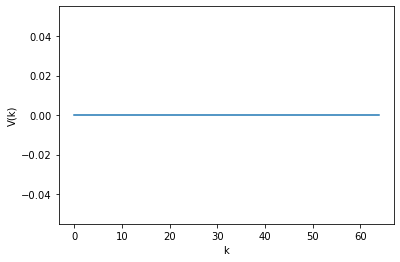

Convergence of the value functions took 348 iterations, in 34.23753595352173 seconds.


In [163]:
qe.tic()
count=0



V=np.empty(shape=[100, 350])
X = np.empty(shape=[100, 100])
G = np.empty(shape=[100, 350])

for s in range(0,349):
    epsilon=0.01
    for i in range(100):
        for j in range(100):
            if X[i,j-1]<X[i,j]: #Concavity
                X[i,j]=M[i,j]+(beta*V[:,s][j])        
   
            V[:,s+1][i]= np.amax(X[:,i]) #Iteration
            G[:,s][i]=np.argmax(X[:,i]) 
    for i in range(0,100):
        if abs(V[:,s+1][i]-V[:,s][i])> epsilon:
            continue
        else:
            count +=1
            break

T = qe.toc()


plt.plot(k, V)       
plt.xlabel('k')
plt.ylabel('V(k)')
plt.show()

print("Convergence of the value functions took "+str(s)+" iterations, in " + str(T) +" seconds.")



## Local search on the decision rule

 We exploit the property that the optimal decision rule is continuous.
        
Hence, if we know that $k_{j} = g(k_{i})$, and we have reasonable fine grids, then we hope that $g(k_{t+1}$ is in a small neighbourhood of $k_{j}$. This restricts the elements of $X$ that need to be computed.
        
Local search is following by practitioners as it has been proved useful. But there is not theorem behind this. We need to check that the bounds that define the neighbourhood are not binding at each iteration. Notice, we need to store the decision rule at the end of each iteration.

TOC: Elapsed: 0:00:5.48


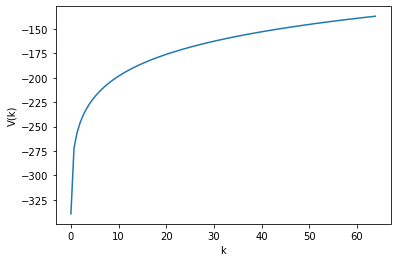

Convergence of the value functions took 348 iterations, in 5.485292673110962 seconds.


In [104]:
qe.tic()
count=0


V_1 = np.empty(shape=[100, 350])
V_1[:,0]=np.zeros((100))
G_1 = np.empty(shape=[100, 350])
X_1 = np.empty(shape=[100, 350]) 
for s in range(0,349):
    epsilon=0.01
    for i in range(99):
        for j in range(100):
            if j==G_1[:,s+1][i+1] or j==G_1[:,s+1][i-1]:  
                X_1[i,j]=M[i,j]+(beta*V_1[:,s][j])
                X_1[np.isnan(X_1)] = 0 
    for i in range(0,100):
        V_1[:,s+1][i]= np.amax(X_1[i,:])
        G_1[:,s]=np.argmax(X_1[i,:])
    for i in range(0,100):
        if abs(V_1[:,s+1][i]-V_1[:,s][i]) >= epsilon:
            count +=1
            continue
        else:
            break

T = qe.toc()


plt.plot(k1, V[:,349])       
plt.xlabel('k')
plt.ylabel('V(k)')
plt.show()

print("Convergence of the value functions took "+str(s)+" iterations, in " + str(T) +" seconds.")


## Monotonicity and Concavity

TOC: Elapsed: 0:00:2.95


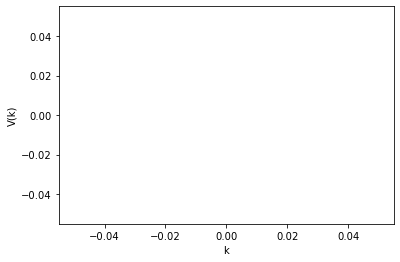

Convergence of the value functions took 348 iterations, in 2.9551303386688232 seconds.


In [164]:
qe.tic()
count=0

V1=np.empty(shape=[100, 350])
X1 = np.empty(shape=[100, 100])
G = np.empty(shape=[100, 350])
count=0
for s in range(0,349):
    epsilon=0.01
    for i in range(100):
        for j in range(100):
            if j >= G[:,s+1][i]: #Monotonicity
                if X1[i,j-1]<X1[i,j]: #Concavity
                    X1[i,j]=M[i,j]+(beta*V[:,s][j])        
    for i in range(0,100):
        V1[:,s+1][i]= np.amax(X1[:,i]) 
        G[:,s][i]=np.argmax(X1[:,i]) 
    for i in range(0,100):
        if abs(V1[:,s+1][i]-V1[:,s][i])> epsilon:
            continue
        else:
            count +=1
            break
T = qe.toc()


k1=np.linspace(0.01,1.5*k_ss,100)
plt.plot(k1, V[:,349])       
plt.xlabel('k')
plt.ylabel('V(k)')
plt.show()


print("Convergence of the value functions took "+str(s)+" iterations, in " + str(T) +" seconds.")
                

## Howard's policy iterations

This method is not depend on the properties of the optimal value function, or decision rule. We can apply a guessed decision rule many times to update the value function many times, without solving for the optimal rule at each iteration. We decide how many times $n_h$ to update the value function without updating the decision rule. If we have a decision rule that is not far from the optimal one, higher $n_h$ implies faster convergence, but iterating on the value function while keeping a decision rule obtained in early stages of the VFI might not be that useful. we will store the decision rule at the end of each iteration.

TOC: Elapsed: 0:00:0.00


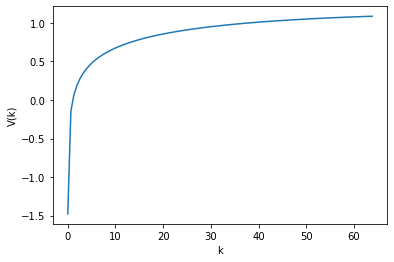

Convergence of the value functions took 0 iterations, in 0.0049860477447509766 seconds.


In [139]:
qe.tic()

# discretize the state space:
kSS = ((1/beta-1+delta)/(1-theta))**(-1/theta)
nk = 100

# Initial guesses and empty matrices:
g0 = np.transpose(np.arange(0,100))    
g = np.empty([nk, 1])  
gki = np.empty([nk, 1])
gkj = np.empty([nk, 1])
gc = np.empty([nk, 1])

epsilon = 0.01 
convergence = False
s = 0
S = 500
kappa = 5.24
nu=2
X = np.empty([nk, nk])
V0 = np.zeros([nk,1])
V = np.empty([nk,1])


while (s < S) and (convergence == False):
    for i in range(nk):
        gki[i] = k[int(g0[i])]
        #gc[i] = k[i]**(1- theta) + (1-delta)*k[i] - gki[i] - (kappa/(1+(1/nu)))
        gc[i] = k[i]**(1- theta) + (1-delta)*k[i] - gki[i]
        V[i] = np.max(np.log(gc[i]) + beta*V0[i])
        g[i] = np.argmax(np.log(gc[i]) + beta*V0[i])   
    for i in range(nk):
        gkj[i] = k[int(g[i])]
        gc[i] = k[i]**(1- theta) + (1-delta)*k[i] - gkj[i]    
    if np.max(gkj - gki)>= epsilon:
        gki = np.copy(gkj)
        gkj = np.empty([nk,1])
        s += 1
    else:
        convergence = True
        
T = qe.toc()        
        
plt.plot(k, V, label='V(k)')  
plt.xlabel('k')
plt.ylabel('V(k)')     
plt.show()
print("Convergence of the value functions took "+str(s)+" iterations, in " + str(T) +" seconds.")
                

### Conclusions

We can observe that for monotonicty concavity iterations the performance it have been working badly, we can observe this in the time to find a maximum. May be I have introduced a lot of loop but I tried to follow and structure with respect to the part a). To the policy function I tried to do something diferent because the first method that I used it wasn't working. So, in my met with Albert, he helped me and he also gave me some ideas. So, I used the option while obviously I had to define a new problem, I think is wrong because the time is practically zero.

Concavity and monotonicty \& concavity aren't be ploted, I think I didn't define the concavity form well. But the problem give me the time, althoug may be si wrong I can take an interpretation. Since, the time decrease monotonicity and concavity is more efficiente algorithm. Notice, that both separete are less efficient. 

I was trying to graph the policy function, but I can not do it.

## Labour Supply

###### Here, I do in the same that in exercis A


TOC: Elapsed: 0:00:24.13
Convergence of the value functions took 348 iterations, in 24.13136124610901 seconds.


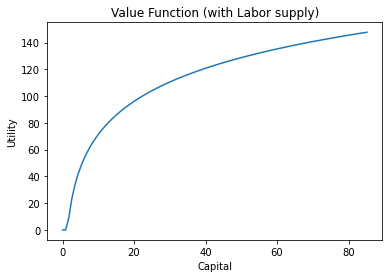

In [38]:
qe.tic()

beta=0.988   
theta=.679
delta=.013
kappa=5.24
nu=2


# STEP 1: DISCRETIZE THE STATE SPACE. 
k_ss=(1/(1-theta)*((1/beta)+delta-1))**(-1/theta)
k=np.linspace(0.01,1.5*k_ss,100)#evenly spaced grid. 
h=np.linspace(0,1,5)

#STEP 2: Initial guess
 
V = np.empty(shape=[100, 350])
#Guess the initial column vector
V[:,0]=np.zeros((100))


#STEP 3: Feasible return matrix (M).

K_i,K_j,H =np.meshgrid(k,k,h)

# Feasible combinations
def feasibility(k_i,k_j,h):
    return (k_i**(1-theta))*(h**theta) + (1-delta)*k_i - k_j


N = feasibility(K_i,K_j,H)


def utility(k_i,k_j,h):
       for i,j,m in zip(range(0,100),range(0,100),range(0,5)):
        if N[i,j,m]>=0:
            return np.log10(k_i**(1-theta)*(h**theta) + (1-delta)*k_i - k_j) - (kappa/(1+(1/nu)))*(h**(1+(1/nu)))
   
            

M = utility(K_i,K_j,H)
np.shape(M)
M[np.isnan(M)] = 0


X = np.empty(shape=[100, 100, 5])
G= np.empty(shape=[100, 350])
count=0
for s in range(0,349):
    epsilon=0.01
    for i in range(100):
        for j in range(100):
            for m in range(5):
                X[i,j,m]=M[i,j,m]+(beta*V[:,s][j])
    for i in range(0,100):
        V[:,s+1][i]= np.amax(X[:,i]) 
        G[:,s][i]=np.argmax(X[:,i]) 
    for i in range(0,100):
        if abs(V[:,s+1][i]-V[:,s][i])< epsilon:
            count +=1
            break
        else:
            continue


T = qe.toc()

k=np.linspace(0.01,2*k_ss,100)
plt.plot(k,V[:,349])
plt.xlabel('Capital')
plt.ylabel('V(k)')
print("Convergence of the value functions took "+str(s)+" iterations, in " + str(T) +" seconds.")

### Conclusions

We can observe since the labour is ondegenous now, the time of the loop is higher. It is normally because the variables that we search are two.

Maybe the code that I used below is more efficiente, but I am not sure that is well.

#####  Here, I try to do elaborate a continuous iteration function follow QuanMacro

TOC: Elapsed: 0:00:10.22
Convergence of the value functions took 348 iterations, in 10.221211910247803 seconds.


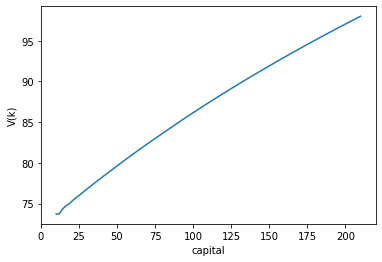

In [166]:
#Follow QuanMacro(Prove)


def sslabor(x):
    F = np.zeros(2)
    kt = x[0]
    ht = x[1]
    F[0] = 1/beta - (1-theta)*kt**(-theta)*ht**(theta)-(1-delta)
    F[1] = theta*kt**(-theta)*ht**(theta-1) - kappa*(kt**(-theta)*ht**(theta)- delta)
    return F
khguess = np.ones(2)
kss, hss = fsolve(sslabor,khguess)


#second step making the grid:
qe.tic()
k_min =10
k_max = 210
n_k = 200
h_min = 0.15
h_max = 0.6
n_h = 50


k = np.linspace(k_min, k_max, n_k) 
h = np.linspace(h_min,h_max,n_h)
k1k1, hh, k2k2 = np.meshgrid(k,h,k)

def retlabor(k1,h,k2):
    c = k1**(1-theta)*h**(theta)- k2 + (1-delta)*k1
    l = kappa*h**(nu)/nu
    if c<0:
        c = 0.0000000001
    return np.log(c)-l

vectrect = np.vectorize(retlabor)
M = vectrect(k1k1,hh,k2k2)
V0 = np.zeros(200)

def bellmanlabor(M,V0):
    X = np.ones(2000000).reshape(50,200,200)
    for i in range(50):
            X[i] = M[i]+beta*V0
    C=0
    while C<1000:
        V0 = np.amax(np.amax(X, axis= 2), axis=0)
        for i in range(50):
            X[i] = M[i]+beta*V0
        C = C+1
    for i in range(50):
            X[i] = M[i]+beta*V0
    nh = np.argmax(np.amax(X, axis=2), axis=0)# Policy for labor
    nk = np.zeros(200)
    for i in range(200):
        nk[i] = np.argmax(X[int(nh[i])][i])# Policy for capital
    X = np.ones(2000000).reshape(50,200,200)
    for i in range(50):
            X[i] = M[i]+beta*V0
    return V0, nh, nk, X
      
V0, nh, nk, X = bellmanlabor(M,V0)

T = qe.toc()
plt.plot(k,V0,)
plt.xlabel('capital')
plt.ylabel('V(k)')

print("Convergence of the value functions took "+str(s)+" iterations, in " + str(T) +" seconds.")

## Chebyshev

Chebyshev regression (Algorithm 6.2 in Judd 1998)

Step 1: Compute the $m \geq n+1 $ Chebyshev interpolation nodes in $[-1, 1]$.
    
\begin{equation*}
        z_{k} = -cos\left(\dfrac{2k-1}{2m}\pi\right), k = 1, \cdots, m
    \end{equation*}
Step 2: Adjust the nodes to the $[a, b]$ interval:
    
 \begin{equation*}
        x_{k} = (z_{k} + 1) \left(\dfrac{b-a}{2}\right) + a, k = 1, \cdots, m
    \end{equation*}
    
Step 3: Evaluate $f$ at the approximation nodes: $w_{k} = f(x_{k}), k = 1, \cdots, m.$
    
Step 4: Compute the Chebyshev coefficients, $\theta_{i}$, associated with Chebyshev basis $i = 0, \cdots, n:$
    
  \begin{equation*}
        \theta_{i} = \dfrac{\sum_{k=1}^{m} w_{k} \psi_i(z_k)}{\sum_{k=1}^{m} \psi_i(z_k) \psi_i(z_k)}
    \end{equation*}
    
  to arrive at the approximation for f(x), $x \in [a,b]$:
    
  \begin{equation*}
        \tilde{f}(x) = \sum_{i=0}^{n} \theta_{i} \psi_{i} \left(2\dfrac{x-a}{b-a}-1\right)
    \end{equation*}

I will follow the Majoto Nakajima' notes:

TOC: Elapsed: 0:00:0.41
Convergence of the value functions took 348 iterations, in 0.41937708854675293 seconds.


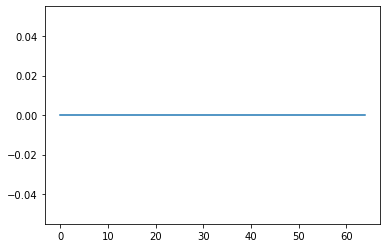

In [171]:


#STEP 1: Set the order of polynomials used for approximation.
n=3

#STEP 2: Set the tolerance parameter
epsilon=0.01

#STEP 3: Upper and lower bound of the discrete space state
beta=0.988   
theta=.679
delta=.013
kappa=5.24
nu=2
k_ss=(1/(1-theta)*((1/beta)+delta-1))**(-1/theta)
k=np.linspace(0.01,1.5*k_ss,100)#evenly spaced grid. 

#STEP 4: Compute the collocations nodes. 
# a) Cheby nodes [-1,1]
nodes=[]
for i in range(100):
    q=np.cos((((2*i)-1)/300)*np.pi)
    nodes.append(q)
nodes=np.asarray(nodes)

#b) Adjust the nodes to the k interval:
nod=[]
for i in range(100):
    q=((nodes[i])*((1.5*k_ss - k[0])/2))+ (((1.5*k_ss + k[0])/2))
    nod.append(q)
nod=np.asarray(nod)
    
#STEP 5: Guess for the level of the value function at the points
y0=np.ones(100)

#STEP 5: Get the Chebyshev coefficients
coefficients=np.polynomial.chebyshev.chebfit(nod,y0,n)

#STEP 6: Value function guess
V0=np.polynomial.chebyshev.chebval(k,coefficients)

#STEP 7: Get the policy function
#7.1. Get the feasible return matrix M


K1,K2=np.meshgrid(k,k)
def feasibility(k1,k2):
    return k1**(1-theta) + (1-delta)*k1 - k2
N = feasibility(K1,K2)
def utility(k1,k2):
    for i,j in zip(range(0,100),range(0,100)):
        if N[i,j]>=0:
            return np.log10(k1**(1-theta) + (1-delta)*k1 - k2) - (kappa/(1+(1/nu)))
        else:
            return -1000
M = utility(K1,K2)

#7.2. Get the policy function
X = np.empty(shape=[100, 100])
G0=np.empty(shape=[100,1])
for i,j in zip(range(0,100),range(0,100)):
    X[i,j]=M[i,j]+(beta*V0[j])
    X[np.isnan(X)] = -1000    
for i in range(0,100):
    G0[i]=np.argmax(X[i,:]) 

#STEP 8: Update the value function
y1=np.empty(shape=[100,1])
for i in range(0,100):
    y1[i]=utility(k[i],G0[i])+(beta*V0[i])
y1[np.isnan(y1)] = 0
y1=np.reshape(y1, (100,))

#STEP 9: New guess for the coefficients
coefficients1=np.polynomial.chebyshev.chebfit(nod,y1,n)


#STEP 10: Compare the coefficients:
d=np.amax(abs(coefficients - coefficients1))

#Since the maximum distance is higher than the tolerance level, we go back to step 6. We need a loop.
qe.tic()
count=0
epsilon=0.01
while d>epsilon and count<100:
    V=np.polynomial.chebyshev.chebval(k,coefficients1) #VF guess
    for i in range(100):
        for j in range(100):
            X[i,j]=M[i,j]+(beta*V[j])
            X[np.isnan(X)] = -100000     
        for i in range(0,100): #Policy function
            G0[i]=np.argmax(X[i,:]) 
        for i in range(0,100): #Update the value function
            y1[i]=utility(k[i],G0[i])+(beta*V[i])
            y1[np.isnan(y1)] = 0
            y1=np.reshape(y1, (100,))        
        coefficients1=np.polynomial.chebyshev.chebfit(nod,y1,n)
        d=np.amax(abs(coefficients - coefficients1))
        count +=1

T = qe.toc()


plt.plot(k,V)


print("Convergence of the value functions took "+str(s)+" iterations, in " + str(T) +" seconds.")

The method may be working but something is wrong, the time decrease so the efficient od this algortihm is high but the graph is not working. 